### Transformer_Econder_for_Noise_Prediction

In [36]:
# Libraries

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
import matplotlib.pyplot as plt

# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [28]:
# Positional Encoding , TransformerEncoder


class PositionalEncoding(nn.Module): 
    def __init__(self, channels, max_len=100):  # channels : pe lenght, max_len : maximum length of a sequence 
        super(PositionalEncoding, self).__init__()
        self.channels = channels
        self.max_len = max_len
        self.positional_encoding = self.generate_positional_encoding()

    def generate_positional_encoding(self):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, self.channels, 2).float() / self.channels))
        position = torch.arange(0, self.max_len).unsqueeze(1).float()
        pos_enc_a = torch.sin(position * inv_freq)
        pos_enc_b = torch.cos(position * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=1)
        return pos_enc.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        batch_size, seq_len, input_dim = x.size()
        pe = self.positional_encoding[:, :seq_len, :].to(x.device)
        return x+pe

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Initialize linear layer
        init.xavier_uniform_(self.linear1.weight)
        init.constant_(self.linear1.bias, 0)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x, _ = self.self_attn(x, x, x)
        x = self.dropout(x)
        x += residual  # Add residual connection
        residual = x
        x = self.norm2(x)
        x = F.tanh(self.linear1(x))
        x = self.dropout(x)
        x += residual  # Add residual connection
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout, channels=100):
        super(TransformerEncoder, self).__init__()
        self.positional_encoding = PositionalEncoding(channels)
        self.embedding = nn.Linear(channels, hidden_dim)
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, dropout)
            for _ in range(num_layers)
        ])
        self.prediction_head = nn.Linear(hidden_dim, input_dim)

        # Initialize embedding and prediction head layers
        init.xavier_uniform_(self.embedding.weight)
        init.constant_(self.embedding.bias, 0)
        init.xavier_uniform_(self.prediction_head.weight)
        init.constant_(self.prediction_head.bias, 0)

    def forward(self, x):
        x = self.positional_encoding(x)
        x = self.embedding(x)
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.prediction_head(x)
        return x


# Example usage
input_dim = 32
hidden_dim = 64
num_layers = 4
num_heads = 4
dropout = 0.1
channels = 50

model = TransformerEncoder(input_dim, hidden_dim, num_layers, num_heads, dropout, channels)



In [23]:
# Example input vector
x = torch.randn(32, 10, 1)  # (batch_size, seq_len, input_dim)

# Initialize model parameters
input_dim = 1
hidden_dim = 64
num_layers = 4
num_heads = 4
dropout = 0.1

# Initialize the model
model = TransformerEncoder(input_dim, hidden_dim, num_layers, num_heads, dropout,channels)

# Forward pass
output = model(x)
x.shape

torch.Size([32, 10, 1])

In [24]:
output.shape

torch.Size([32, 10, 1])

In [25]:
# Data class

class CustomDataset(Dataset):
    def __init__(self, size, seq_len, mean, std, noise_mean, noise_std):
        self.size = size
        self.seq_len = seq_len
        self.mean = mean
        self.std = std
        self.noise_mean = noise_mean
        self.noise_std = noise_std
        self.data = self.generate_data()

    def generate_data(self):
        data = []
        for _ in range(self.size):
            sample = np.random.normal(self.mean, self.std, self.seq_len)
            noise = np.random.normal(self.noise_mean, self.noise_std, self.seq_len)
            noisy_sample = sample + noise
            data.append((noisy_sample, noise))  
        return data

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        noisy_sample, noise = self.data[idx]  
        return torch.tensor(noisy_sample, dtype=torch.float32).to(device), torch.tensor(noise, dtype=torch.float32).to(device)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs, device, plot):
    train_losses = []  # Store training losses for plotting
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(2)).squeeze(2)  
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")
    if plot:
        plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.show()


In [ ]:
# Parameters for dataset generation
dataset_size = 10000
seq_len = 20
mean = 100
std = 100
noise_mean = 0
noise_std = 1

# Create dataset and dataloader
dataset = CustomDataset(dataset_size, seq_len, mean, std, noise_mean, noise_std)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example usage of the train_model function
input_dim = 1
hidden_dim = 512
num_layers = 2
num_heads = 1
dropout = 0.1

model = TransformerEncoder(input_dim, hidden_dim, num_layers, num_heads, dropout, channels)
model.to(device)  # Move model to device
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
epochs = 10

train_model(model, train_loader, criterion, optimizer, epochs, device,True)


In [26]:
# Testing funciton

def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs.unsqueeze(2)).squeeze(2)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss}")
    return avg_loss



In [ ]:
# Parameters for test dataset
test_dataset_size = 500

# Create test dataset and dataloader
test_dataset = CustomDataset(test_dataset_size, seq_len, mean, std, noise_mean, noise_std)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test the model
test_loss = test_model(model, test_loader, criterion, device)

# Compare with standard deviation of noise
print(f"Standard deviation of noise: {noise_std}")
if test_loss < noise_std:
    print("Model performance is good relative to noise level.")
else:
    print("Model performance is not satisfactory relative to noise level. Consider further improvement.")

Epoch 1/500, Loss: 47.02586328983307
Epoch 2/500, Loss: 21.385787308216095
Epoch 3/500, Loss: 20.68944239616394
Epoch 4/500, Loss: 20.877672910690308
Epoch 5/500, Loss: 20.71439379453659
Epoch 6/500, Loss: 20.57926219701767
Epoch 7/500, Loss: 20.597962141036987
Epoch 8/500, Loss: 20.67892301082611
Epoch 9/500, Loss: 20.791108906269073
Epoch 10/500, Loss: 20.557223618030548
Epoch 11/500, Loss: 20.60647839307785
Epoch 12/500, Loss: 20.73124188184738
Epoch 13/500, Loss: 20.57864600419998
Epoch 14/500, Loss: 20.73778361082077
Epoch 15/500, Loss: 20.91401696205139
Epoch 16/500, Loss: 20.635303020477295
Epoch 17/500, Loss: 20.63013732433319
Epoch 18/500, Loss: 20.81546324491501
Epoch 19/500, Loss: 20.58168399333954
Epoch 20/500, Loss: 20.53693276643753
Epoch 21/500, Loss: 20.975015580654144
Epoch 22/500, Loss: 20.7349956035614
Epoch 23/500, Loss: 20.625742077827454
Epoch 24/500, Loss: 20.612088441848755
Epoch 25/500, Loss: 20.66093933582306
Epoch 26/500, Loss: 20.631505250930786
Epoch 27/500

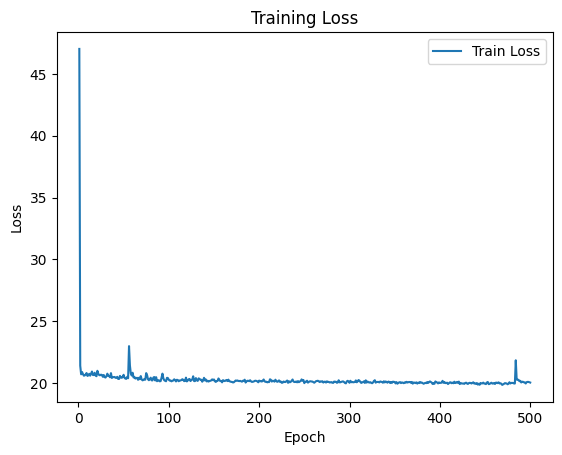

Test Loss: 19.949036189488


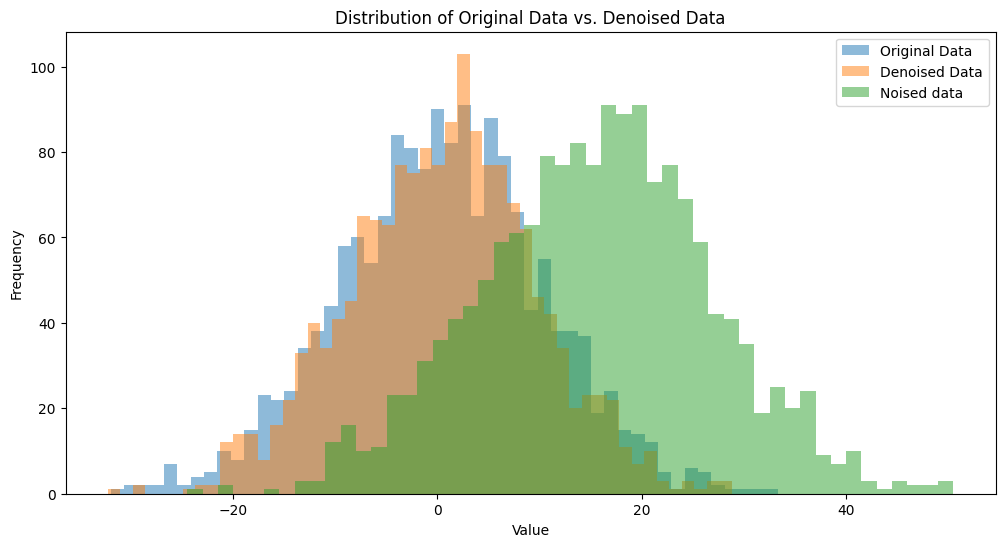

Original Data: Mean=0.3940473794937134, Std=9.990606307983398
Denoised Data: Mean=0.4828844964504242, Std=9.120835304260254


In [29]:
# Training and comapring the original distribution and the denoised distribution predicted by the model

# Parameters
dataset_size = 1000
seq_len = 50
mean = 0
std = 10
noise_mean = 15
noise_std = 5

input_dim = 1
hidden_dim = 1024
num_layers = 3
num_heads = 2
dropout = 0.1
channels = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create dataset and dataloaders
train_dataset = CustomDataset(dataset_size, seq_len, mean, std, noise_mean, noise_std)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset_size = 200
test_dataset = CustomDataset(test_dataset_size, seq_len, mean, std, noise_mean, noise_std)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, criterion, optimizer
model = TransformerEncoder(input_dim, hidden_dim, num_layers, num_heads, dropout, channels)
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 500

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs, device, True)

# Test the model
test_loss = test_model(model, test_loader, criterion, device)

# Visualize distribution of data with and without noise
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.unsqueeze(2)).squeeze(2)
        denoised_data = inputs - outputs
        break  # Just use the first batch for visualization

# Flatten tensors and convert to numpy arrays
inputs = inputs.cpu().numpy().flatten()
targets = targets.cpu().numpy().flatten()
denoised_data = denoised_data.cpu().numpy().flatten()

# Plot distributions
plt.figure(figsize=(12, 6))
plt.hist(inputs-targets, bins=50, alpha=0.5, label='Original Data')
plt.hist(denoised_data, bins=50, alpha=0.5, label='Denoised Data')
plt.hist(inputs, bins=50, alpha=0.5, label='Noised data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Original Data vs. Denoised Data')
plt.legend()
plt.show()

# Find parameters of the distributions
mean_original, std_original = norm.fit(inputs - targets)
mean_denoised, std_denoised = norm.fit(denoised_data)

print(f"Original Data: Mean={mean_original}, Std={std_original}")
print(f"Denoised Data: Mean={mean_denoised}, Std={std_denoised}")

The model is performing quite well; however, cross-validation is necessary to determine the optimal hyperparameters. This is particularly important as the model tends to struggle when the variance of the noise distribution is large. Continued...